# MASK ENERGY

In [2]:
import numpy
import h5py
import time
import os, sys
import random
from collections import OrderedDict
import itertools
import matplotlib.pyplot as plt

In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [4]:
#input_file = 'NuMu_140000_level2_uncleaned_cleanedpulsesonly.lt100_CC_flat_100bins_5000evtperbin.transformed.hdf5'
train_variables = 2
num_labels = train_variables

batch_size = 256
dropout = 0.2
learning_rate = 1e-3
DC_drop_value = dropout
IC_drop_value =dropout
connected_drop_value = dropout
min_energy = 5
max_energy = 100.
num_epochs = 14

filename =  'numu_flat_EZ_5_100_CC_uncleaned_280epochs_test' #'numu_flat_E_5_100_CC_uncleaned_175epochs_test'
save = True
save_folder_name = "output_plots/%s"%(filename)
if save==True:
    if os.path.isdir(save_folder_name) != True:
        os.mkdir(save_folder_name)

        
use_old_weights = True
load_model_name = "numu_flat_EZ_5_100_CC_uncleaned_cleanedpulsesonly_3600kevents_280epochs_model.hdf5" #"output_plots/%s/45epochs/%s_model.hdf5"%(filename,filename) #
use_old_reco = False

In [5]:
#file = "Level5p_IC86.2013_genie_numu.014640.100files.lt100_vertexDC_CC.transformedinputoutput.hdf5"
#file = "Level5p_IC86.2013_genie_numu.014640.100.i3.bz2_lt100_vertexDC_CC.lt100_file00.transformedinputoutput_hardgivenmax.hdf5"
#file = "oscNext_genie_level5_v01.03_pass2.140000.i3.zst_lt100_vertexDC_lt100_CC_flat_100bins_4000evtperbin.transformed.hdf5"
#file = "NuMu_140000_level2_uncleaned_cleanedpulsesonly.lt100_CC_flat_100bins_4000evtperbin.transformed.hdf5"
#file = "NuMu_140000_level2_uncleaned_cleanedpulsesonly.lt100_vertexDC_CC_flat_100bins_16841evtperbin_file00.transformed.hdf5"

# Put all the test sets together
Y_test_use = None
X_test_DC_use = None
X_test_IC_use = None

f = h5py.File(file, 'r')
Y_test = f['Y_test'][:]
X_test_DC = f['X_test_DC'][:]
X_test_IC = f['X_test_IC'][:]
Y_train = f['Y_train'][:]
X_train_DC = f['X_train_DC'][:]
X_train_IC = f['X_train_IC'][:]
Y_validate = f['Y_validate'][:]
X_validate_DC = f['X_validate_DC'][:]
X_validate_IC = f['X_validate_IC'][:]
f.close()
del f

Y_test_use = numpy.concatenate((Y_test,Y_train,Y_validate))
X_test_DC_use = numpy.concatenate((X_test_DC,X_train_DC,X_validate_DC))
X_test_IC_use =numpy.concatenate((X_test_IC,X_train_IC,X_validate_IC))
   
print(Y_test_use.shape)

save_file = False

if save_file:
    split_file_name = file.split('_')
    new_name = split_file_name[0]
    for name in range(1,len(split_file_name)-1):
        new_name = new_name + "_" + split_file_name[name]
    new_name += ".testall.hdf5"

    output_file =  new_name
    print("Output file: %s"%output_file)
    f = h5py.File(output_file, "w")
    f.create_dataset("Y_test", data=Y_test_use)
    f.create_dataset("X_test_DC", data=X_test_DC_use)
    f.create_dataset("X_test_IC", data=X_test_IC_use)
    f.close()

KeyError: "Unable to open object (object 'Y_train' doesn't exist)"

In [23]:
transformed = True
if transformed:
    mask_energy_train = numpy.logical_and(Y_test_use[:,0]>0.05,Y_test_use[:,0]<1.0)

    Y_test_cut = Y_test_use[mask_energy_train]
    X_test_DC_use = X_test_DC_use[mask_energy_train]
    X_test_IC_use = X_test_IC_use[mask_energy_train]
    
    Y_test_use = Y_test_cut[:,:train_variables]

else:

    mask_energy_train = numpy.logical_and(Y_test_use[:,0]>min_energy,Y_test_use[:,0]<max_energy)

    Y_test_cut = Y_test_use[mask_energy_train]
    X_test_DC_use = X_test_DC_use[mask_energy_train]
    X_test_IC_use = X_test_IC_use[mask_energy_train]

    maxabs = max_energy #Divide energy by maxabs
    Y_test_use =  numpy.zeros((Y_test_cut.shape[0],num_labels))
    Y_test_use[:,0] = Y_test_cut[:,0]/float(maxabs) #energy
    if num_labels > 1:
        Y_test_use[:,1] = numpy.cos(Y_test_cut[:,1]) #cos zenith

Fraction CC: 1.000000


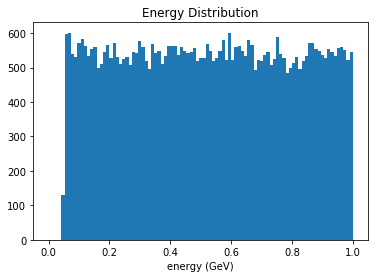

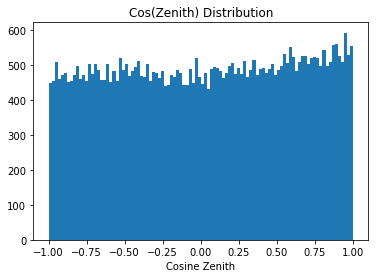

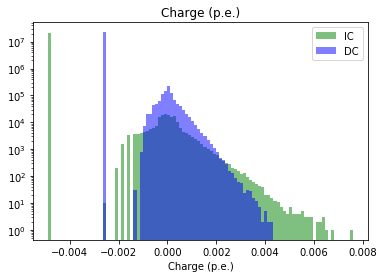

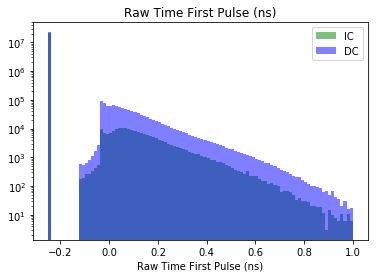

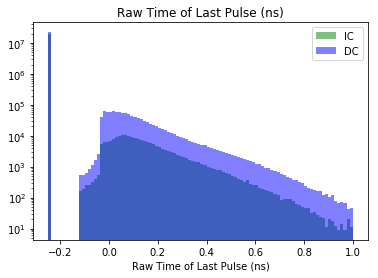

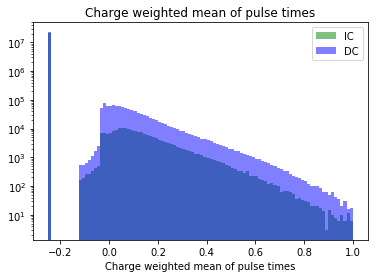

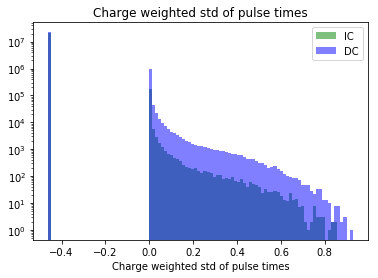

In [7]:
plt.figure()
plt.hist(Y_test_use[:,0],bins=95,range=(0.,1.));
plt.title("Energy Distribution")
plt.xlabel("energy (GeV)")

if train_variables > 1:
    plt.figure()
    plt.hist(Y_test_use[:,1],bins=100);
    plt.title("Cos(Zenith) Distribution")
    plt.xlabel("Cosine Zenith")

print("Fraction CC: %f"%(sum(Y_test[:,11])/len(Y_test[:,11])))
mask = Y_test[:,9]==14
if sum(mask) < len(Y_test):
    print("PANIC")


name = ["Charge (p.e.)", "Raw Time First Pulse (ns)", "Raw Time of Last Pulse (ns)", "Charge weighted mean of pulse times", "Charge weighted std of pulse times"]
unclean_label = "IC"
clean_label = "DC"
for i in range(0,X_test_DC.shape[-1]):

    clean_data = X_test_DC[...,i].flatten()
    unclean_data = X_test_IC[...,i].flatten()

    min_range = min(min(clean_data),min(unclean_data))
    max_range = max(max(clean_data),max(unclean_data))
    plt.figure()
    plt.hist(unclean_data,log=True,bins=100,range=[min_range,max_range],color='g',label=unclean_label,alpha=0.5);
    plt.hist(clean_data,log=True,bins=100,range=[min_range,max_range],color='b',label=clean_label,alpha=0.5);
    plt.title(name[i])
    plt.xlabel(name[i])
    plt.legend()

In [25]:
X_train_DC = X_test_DC_use
X_train_IC = X_test_IC_use

In [26]:
### Build The Network ##
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Lambda
from keras.layers import concatenate
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras import initializers
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


## MIRCO NETWORK ##

# DEEP CORE #
#print("Train Data DC", X_train_DC.shape)
strings = X_train_DC.shape[1]
dom_per_string = X_train_DC.shape[2]
dom_variables = X_train_DC.shape[3]

# Conv DC + batch normalization, later dropout and maxpooling
input_DC = Input(shape=(strings, dom_per_string, dom_variables))

conv1_DC = Conv2D(100,kernel_size=(strings,5),padding='same',activation='tanh')(input_DC)
batch1_DC = BatchNormalization()(conv1_DC)
pool1_DC = MaxPooling2D(pool_size=(1,2))(batch1_DC)
drop1_DC = Dropout(DC_drop_value)(pool1_DC)

conv2_DC = Conv2D(100,kernel_size=(strings,7),padding='same',activation='relu')(drop1_DC)
batch2_DC = BatchNormalization()(conv2_DC)
drop2_DC = Dropout(DC_drop_value)(batch2_DC)

conv3_DC = Conv2D(100,kernel_size=(strings,7),padding='same',activation='relu')(drop2_DC)
batch3_DC = BatchNormalization()(conv3_DC)
drop3_DC = Dropout(DC_drop_value)(batch3_DC)

conv4_DC = Conv2D(100,kernel_size=(strings,3),padding='valid',activation='relu')(drop3_DC)
batch4_DC = BatchNormalization()(conv4_DC)
pool4_DC = MaxPooling2D(pool_size=(1,2))(batch4_DC)
drop4_DC = Dropout(DC_drop_value)(pool4_DC)

conv5_DC = Conv2D(100,kernel_size=(1,7),padding='same',activation='relu')(drop4_DC)
batch5_DC = BatchNormalization()(conv5_DC)
drop5_DC = Dropout(DC_drop_value)(batch5_DC)

conv6_DC = Conv2D(100,kernel_size=(1,7),padding='same',activation='relu')(drop5_DC)
batch6_DC = BatchNormalization()(conv6_DC)
drop6_DC = Dropout(DC_drop_value)(batch6_DC)

conv7_DC = Conv2D(100,kernel_size=(1,1),padding='same',activation='relu')(drop6_DC)
batch7_DC = BatchNormalization()(conv7_DC)
drop7_DC = Dropout(DC_drop_value)(batch7_DC)

conv8_DC = Conv2D(100,kernel_size=(1,1),padding='same',activation='relu')(drop7_DC)
batch8_DC = BatchNormalization()(conv8_DC)
drop8_DC = Dropout(DC_drop_value)(batch8_DC)

flat_DC = Flatten()(drop8_DC)


# ICECUBE NEAR DEEPCORE #
#print("Train Data IC", X_train_IC.shape)
strings_IC = X_train_IC.shape[1]
dom_per_string_IC = X_train_IC.shape[2]
dom_variables_IC = X_train_IC.shape[3]

# Conv DC + batch normalization, later dropout and maxpooling
input_IC = Input(shape=(strings_IC, dom_per_string_IC, dom_variables_IC))

conv1_IC = Conv2D(100,kernel_size=(strings_IC,5),padding='same',activation='tanh')(input_IC)
batch1_IC = BatchNormalization()(conv1_IC)
pool1_IC = MaxPooling2D(pool_size=(1,2))(batch1_IC)
drop1_IC = Dropout(IC_drop_value)(pool1_IC)

conv2_IC = Conv2D(100,kernel_size=(strings_IC,7),padding='same',activation='relu')(drop1_IC)
batch2_IC = BatchNormalization()(conv2_IC)
drop2_IC = Dropout(IC_drop_value)(batch2_IC)

conv3_IC = Conv2D(100,kernel_size=(strings_IC,7),padding='same',activation='relu')(drop2_IC)
batch3_IC = BatchNormalization()(conv3_IC)
drop3_IC = Dropout(IC_drop_value)(batch3_IC)

conv4_IC = Conv2D(100,kernel_size=(strings_IC,3),padding='valid',activation='relu')(drop3_IC)
batch4_IC = BatchNormalization()(conv4_IC)
pool4_IC = MaxPooling2D(pool_size=(1,2))(batch4_IC)
drop4_IC = Dropout(IC_drop_value)(pool4_IC)

conv5_IC = Conv2D(100,kernel_size=(1,7),padding='same',activation='relu')(drop4_IC)
batch5_IC = BatchNormalization()(conv5_IC)
drop5_IC = Dropout(IC_drop_value)(batch5_IC)

conv6_IC = Conv2D(100,kernel_size=(1,7),padding='same',activation='relu')(drop5_IC)
batch6_IC = BatchNormalization()(conv6_IC)
drop6_IC = Dropout(IC_drop_value)(batch6_IC)

conv7_IC = Conv2D(100,kernel_size=(1,1),padding='same',activation='relu')(drop6_IC)
batch7_IC = BatchNormalization()(conv7_IC)
drop7_IC = Dropout(IC_drop_value)(batch7_IC)

conv8_IC = Conv2D(100,kernel_size=(1,1),padding='same',activation='relu')(drop7_IC)
batch8_IC = BatchNormalization()(conv8_IC)
drop8_IC = Dropout(IC_drop_value)(batch8_IC)

flat_IC = Flatten()(drop8_IC)


# PUT TOGETHER #
concatted = concatenate([flat_DC, flat_IC])

full1 = Dense(300,activation='relu')(concatted)
batch1_full = BatchNormalization()(full1)
dropf = Dropout(connected_drop_value)(batch1_full)

output = Dense(num_labels,activation='linear')(dropf)
model_DC = Model(inputs=[input_DC,input_IC],outputs=output)


In [27]:
# WRITE OWN LOSS FOR MORE THAN ONE REGRESSION OUTPUT
from keras.losses import mean_squared_error
from keras.losses import mean_squared_logarithmic_error
from keras.losses import logcosh

def EnergyLoss(y_truth,y_predicted):
    #return mean_squared_logarithmic_error(y_truth[:,0],y_predicted[:,0]) #/120.
    return mean_squared_error(y_truth[:,0],y_predicted[:,0])

def ZenithLoss(y_truth,y_predicted):
    #return logcosh(y_truth[:,1],y_predicted[:,1])
    return mean_squared_error(y_truth[:,1],y_predicted[:,1])

def TrackLoss(y_truth,y_predicted):
    return mean_squared_logarithmic_error(y_truth[:,2],y_predicted[:,2])/100.

## Compile ##
if num_labels == 3:
    def CustomLoss(y_truth,y_predicted):
        energy_loss = EnergyLoss(y_truth,y_predicted)
        zenith_loss = ZenithLoss(y_truth,y_predicted)
        track_loss = TrackLoss(y_truth,y_predicted)
        return energy_loss + zenith_loss + track_loss

    model_DC.compile(loss=CustomLoss,
              optimizer=Adam(lr=learning_rate),
              metrics=[EnergyLoss,ZenithLoss,TrackLoss])

elif num_labels == 2:
    def CustomLoss(y_truth,y_predicted):
        energy_loss = EnergyLoss(y_truth,y_predicted)
        zenith_loss = ZenithLoss(y_truth,y_predicted)
        return energy_loss + zenith_loss

    model_DC.compile(loss=CustomLoss,
              optimizer=Adam(lr=learning_rate),
              metrics=[EnergyLoss,ZenithLoss])
    print("Using 2 variables")
    
else:
    def CustomLoss(y_truth,y_predicted):
        energy_loss = EnergyLoss(y_truth,y_predicted)
        return energy_loss

    model_DC.compile(loss=EnergyLoss,
                optimizer=Adam(lr=learning_rate),
                metrics=[EnergyLoss])


Using 2 variables


In [28]:
model_DC.load_weights(load_model_name)
print("Using model: %s"%load_model_name)

Using model: numu_flat_EZ_5_100_CC_uncleaned_cleanedpulsesonly_3600kevents_280epochs_model.hdf5


In [29]:
t0 = time.time()
Y_test_predicted = model_DC.predict([X_test_DC_use,X_test_IC_use])
t1 = time.time()
print("This took me %f seconds for %i events"%(((t1-t0)),Y_test_predicted.shape[0]))

This took me 32.618837 seconds for 106394 events


In [30]:
from PlottingFunctions import plot_single_resolution
from PlottingFunctions import plot_2D_prediction
from PlottingFunctions import plot_history
from PlottingFunctions import plot_bin_slices

In [34]:
def plot_bin_slices(truth, nn_reco, true_energy = None, \
                       min_energy = 0., max_energy = 100., \
                       use_fraction = False, use_old_reco = False, old_reco=None,\
                       bins=10,min_val=0.,max_val=60.,\
                       save=False,savefolder=None,\
                       variable="Energy",units="GeV"):
    """Plots different variable slices vs each other (systematic set arrays)
    Receives:
        truth= array with truth labels
                (contents = [energy], shape = number of events)
        nn_reco = array that has NN predicted reco results
                    (contents = [energy], shape = number of events)
        use_fraction = bool, use fractional resolution instead of absolute, where (reco - truth)/truth
        use_old_reco = bool, True if you want to compare to another reconstruction (like pegleg)
        old_reco = optional, array of pegleg labels
                (contents = [energy], shape = number of events)
        bins = integer number of data points you want (range/bins = width)
        min_val = minimum value for variable to start cut at (default = 0.)
        max_val = maximum value for variable to end cut at (default = 60.)
    Returns:
        Scatter plot with energy values on x axis (median of bin width)
        y axis has median of resolution with error bars containing 68% of resolution
    """
    if use_fraction:
        resolution = ((nn_reco-truth)/truth) # in fraction
    else:
        resolution = (nn_reco-truth)

    percentile_in_peak = 68.27

    left_tail_percentile  = (100.-percentile_in_peak)/2
    right_tail_percentile = 100.-left_tail_percentile
    
    if true_energy is None:
        variable_ranges  = numpy.linspace(min_val,max_val, num=bins)
    else:
        variable_ranges  = numpy.linspace(min_energy,max_energy, num=bins)
    
    variable_centers = (variable_ranges[1:] + variable_ranges[:-1])/2.

    medians  = numpy.zeros(len(variable_centers))
    err_from = numpy.zeros(len(variable_centers))
    err_to   = numpy.zeros(len(variable_centers))

    if use_old_reco:
        if use_fraction:
            resolution_reco = ((old_reco-truth)/truth)
        else:
            resolution_reco = (old_reco-truth)
        medians_reco  = numpy.zeros(len(variable_centers))
        err_from_reco = numpy.zeros(len(variable_centers))
        err_to_reco   = numpy.zeros(len(variable_centers))
    
    for i in range(len(variable_ranges)-1):
        var_from = variable_ranges[i]
        var_to   = variable_ranges[i+1]
        
        if true_energy is None:
            cut = (truth >= var_from) & (truth < var_to)
        else:
            cut = (true_energy*max_energy >= var_from) & (true_energy*max_energy < var_to)

        lower_lim = numpy.percentile(resolution[cut], left_tail_percentile)
        upper_lim = numpy.percentile(resolution[cut], right_tail_percentile)
        median = numpy.percentile(resolution[cut], 50.)
        
        medians[i] = median
        err_from[i] = lower_lim
        err_to[i] = upper_lim
        
        if use_old_reco:
            lower_lim_reco = numpy.percentile(resolution_reco[cut], left_tail_percentile)
            upper_lim_reco = numpy.percentile(resolution_reco[cut], right_tail_percentile)
            median_reco = numpy.percentile(resolution_reco[cut], 50.)

            medians_reco[i] = median_reco
            err_from_reco[i] = lower_lim_reco
            err_to_reco[i] = upper_lim_reco

    plt.figure(figsize=(10,7))
    plt.errorbar(variable_centers, medians, yerr=[medians-err_from, err_to-medians], xerr=[ variable_centers-variable_ranges[:-1], variable_ranges[1:]-variable_centers ], capsize=5.0, fmt='o',label="NN Reco")
    if use_old_reco:
        plt.errorbar(variable_centers, medians_reco, yerr=[medians_reco-err_from_reco, err_to_reco-medians_reco], xerr=[ variable_centers-variable_ranges[:-1], variable_ranges[1:]-variable_centers ], capsize=5.0, fmt='o',label="Pegleg Reco")
        plt.legend(loc="upper center")
    if true_energy is None:
        plt.plot([min_val,max_val], [0,0], color='k')
        plt.xlim(min_val,max_val)
        plt.xlabel("%s Range (%s)"%(variable,units))
    else:
        plt.plot([min_energy,max_energy], [0,0], color='k')
        plt.xlim(min_energy,max_energy)
        plt.xlabel("Energy (GeV)")
    if variable=="Energy":
        plt.ylim(-.3,1.3)
    #if variable=="CosZenith":
    #    plt.ylim(-1.,.7)
    
    if use_fraction:
        plt.ylabel("Fractional Resolution: \n (reconstruction - truth)/truth")
    else:
         plt.ylabel("Resolution: \n reconstruction - truth (%s)"%units)
    plt.title("Resolution %s Dependence"%variable)

    savename = "%sResolutionSlices"%variable
    if use_fraction:
        savename += "Frac"
    if use_old_reco:
        savename += "_CompareOldReco"
    if save == True:
        plt.savefig("%s%s.png"%(savefolder,savename))

In [35]:
def plot_distributions(truth,reco,save=False,savefolder=None,variable="Energy",units="GeV"):
    """
    Plot testing set distribution, with CC and NC distinguished
    Recieves:
        truth_all_labels = array, Y_test truth labels that have ALL values in them (need CC vs NC info)
        truth = array, Y_test truth labels
        reco = array, neural network prediction output
        save = optional, bool to save plot
        savefolder = optional, output folder to save to, if not in current dir
    Returns:
        1D histogram of reco - true with sepearated CC and NC distinction
    """
    print(len(truth),len(reco))
    plt.figure(figsize=(10,7))
    plt.title("%s Distribution"%variable)
    plt.hist(truth, bins=100,color='b',alpha=0.5,label="Truth");
    plt.hist(reco, bins=100,color='g', alpha=0.5, label="Neural Net");
    plt.xlabel("%s (%s)"%(variable,units))
    plt.legend()
    if save:
        plt.savefig("%s%sDistribution.png"%(savefolder,variable))

106394 106394
106394 106394


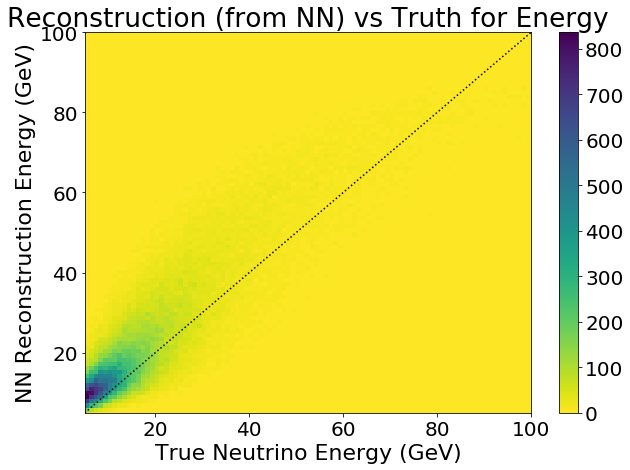

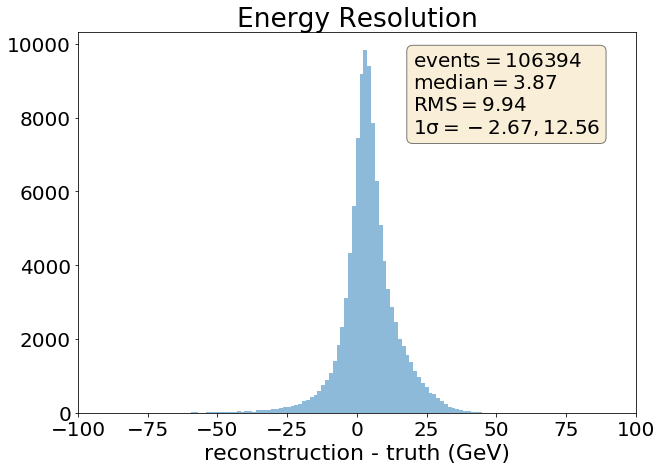

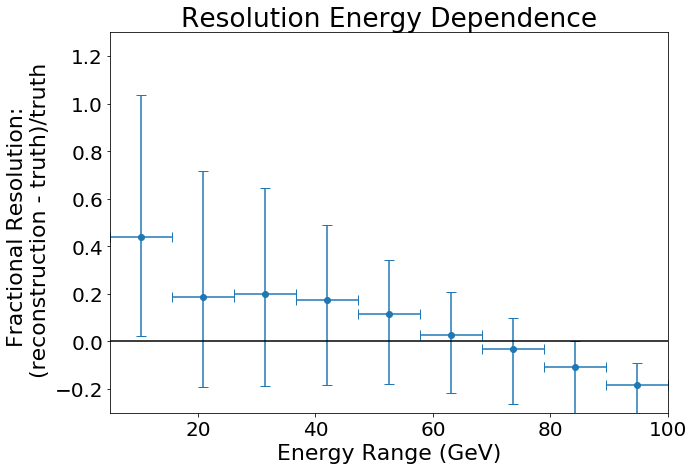

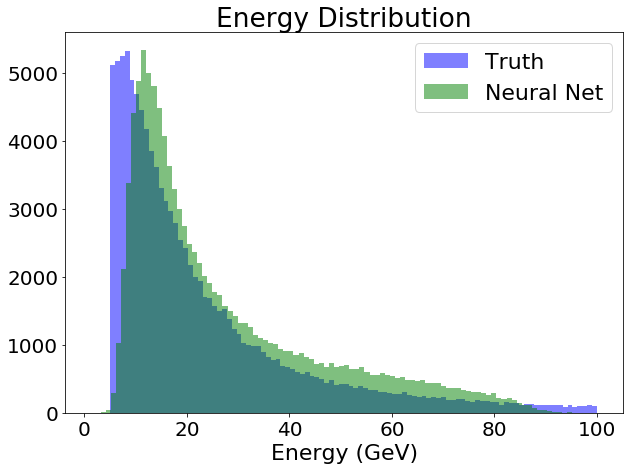

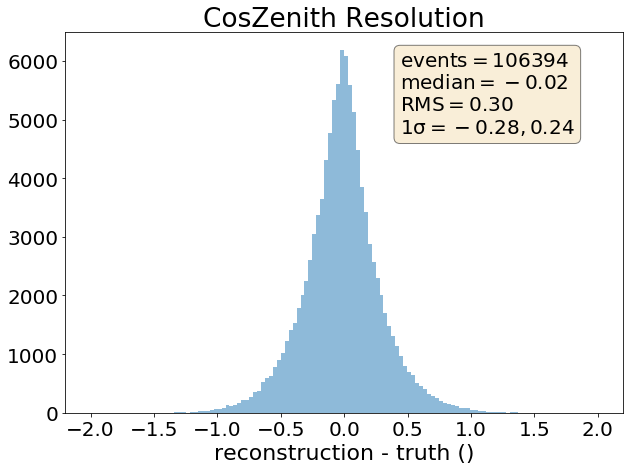

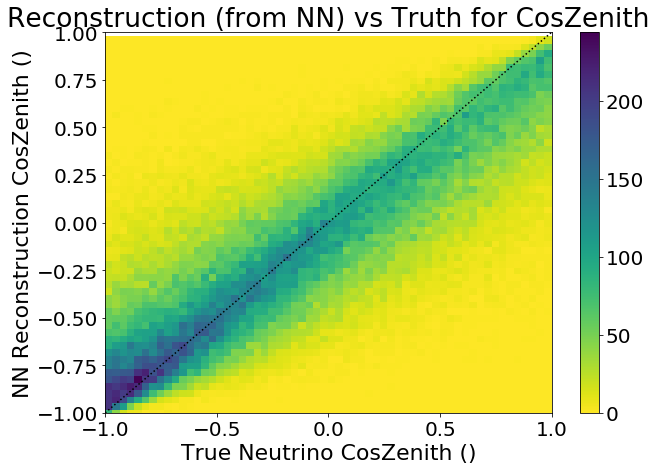

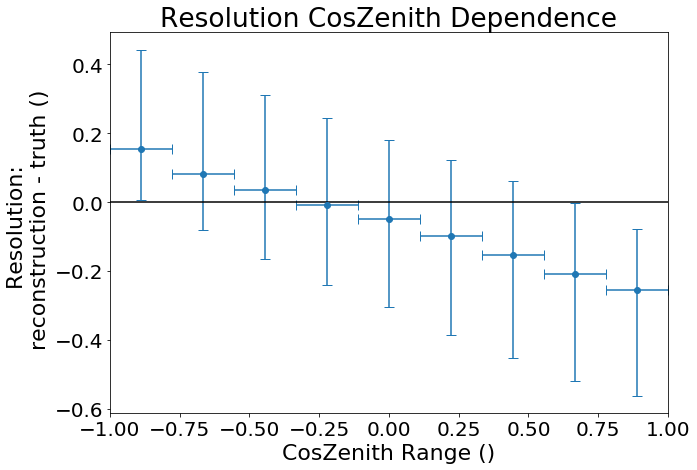

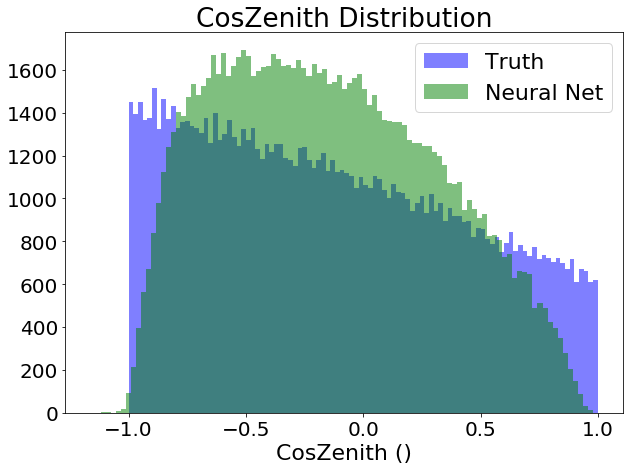

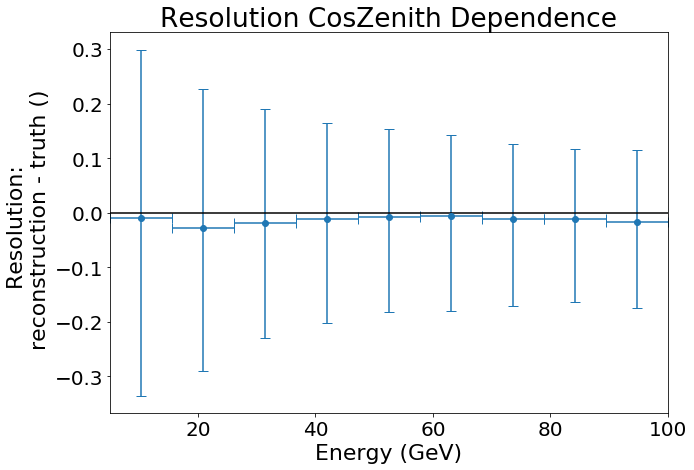

In [36]:
#plot_history(network_history,save,save_folder_name)

plot_2D_prediction(Y_test_use[:,0]*max_energy, Y_test_predicted[:,0]*max_energy,save,save_folder_name,bins=int(max_energy-min_energy),minval=min_energy,maxval=max_energy,variable="Energy",units='GeV')
plot_single_resolution(Y_test_use[:,0]*max_energy, Y_test_predicted[:,0]*max_energy,\
                       save=save,savefolder=save_folder_name,\
                       variable="Energy",units='GeV')
plot_bin_slices(Y_test_use[:,0]*max_energy, Y_test_predicted[:,0]*max_energy, \
                       use_fraction = True, \
                       bins=10,min_val=5.,max_val=100.,\
                       save=True,savefolder=save_folder_name,\
                       variable="Energy",units="GeV")
plot_distributions(Y_test_use[:,0]*max_energy, Y_test_predicted[:,0]*max_energy,save,save_folder_name,variable="Energy",units='GeV')

if num_labels > 1:
    plot_single_resolution(Y_test_use[:,1], Y_test_predicted[:,1],\
                       save=save,savefolder=save_folder_name,\
                       variable="CosZenith",units='')
    plot_2D_prediction(Y_test_use[:,1], Y_test_predicted[:,1],save,save_folder_name,minval=-1,maxval=1,variable="CosZenith",units='')
    plot_bin_slices(Y_test_use[:,1], Y_test_predicted[:,1], \
                       use_fraction = False, \
                       bins=10,min_val=-1.,max_val=1.,\
                       save=True,savefolder=save_folder_name,\
                       variable="CosZenith",units="")
    plot_distributions(Y_test_use[:,1], Y_test_predicted[:,1],save,save_folder_name,variable="CosZenith",units='')
    plot_bin_slices(Y_test_use[:,1], Y_test_predicted[:,1], \
                       min_energy = 5., max_energy=100., true_energy=Y_test_use[:,0], \
                       use_fraction = False, \
                       bins=10,min_val=-1.,max_val=1.,\
                       save=True,savefolder=save_folder_name,\
                       variable="CosZenith",units="")
    
if num_labels > 2:
    plot_single_resolution(Y_test_use[:,2], Y_test_predicted[:,2],\
                       save=save,savefolder=save_folder_name,\
                       variable="Track",units='m')
    plot_2D_prediction(Y_test_use[:,2], Y_test_predicted[:,2],save,save_folder_name,minval=0,maxval=150,variable="Track",units='m')
